### Bayesian_lstm_predictor_project2_finetune1.ipynb - 3 yrs AAPL data - LSTM model. 
### In this Notebook we will use a Bayesian Optimizer from Keras to optimize and fine tune some of the hyperparameters. Then use what the Tuner suggests and later compare with anaother simple LSTM model and see which does better.

## Data Preparation

In this section, we will prepare the training and testing data for the LSTM model.

We will:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the `X` and `y` values
4. Reshape the `X_train` and `X_test` data for the model.

**Note:** The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

#### Colab installations upfront to access those libraries

In [ ]:
!pip install yfinance
!pip install mplfinance
!pip install keras-tuner

     |████████████████████████████████| 6.3 MB 11.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=cb406846f6822c24bd07f64d1d9667696dbf2550cc68f303d0034bfb63e365d3
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 96 kB 4.6 MB/s 


##### Switch off warnings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

##### Import necessary libraries, packages

In [ ]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mpl_dates
from datetime import date, timedelta
import calendar
from datetime import datetime

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [ ]:
#Set the random seed for reproducibility
#Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

### Data Loading

In this activity, we will use closing prices of Apple stock to make predictions of future closing prices. 
We will use yfinance - Yahoo! Finance market data downloader to get the historical market data

In [ ]:
#set ticker
appl=yf.Ticker("AAPL")

In [ ]:
# get stock info
appl.info

# get historical market data
hist = appl.history(period="max")

In [ ]:
#download data
df = yf.download("AAPL",
                   start="2018-07-04", 
                   end="2021-07-09",
                   period = "1d"
                  )

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Display data
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-05,46.314999,46.602501,46.070000,46.349998,44.747585,66416800
2018-07-06,46.355000,47.107498,46.299999,46.992500,45.367878,69940800
2018-07-09,47.375000,47.669998,47.325001,47.645000,45.997814,79026400
2018-07-10,47.677502,47.820000,47.544998,47.587502,45.942310,63756400
2018-07-11,47.125000,47.445000,46.902500,46.970001,45.346149,75326000
2018-07-12,47.382500,47.852501,47.327499,47.757500,46.106426,72164400
2018-07-13,47.770000,47.959999,47.724998,47.832500,46.178841,50055600
2018-07-16,47.880001,48.162498,47.605000,47.727501,46.077469,60172400
2018-07-17,47.437500,47.967499,47.299999,47.862499,46.207802,62138000


### Creating the Features `X` and Target `y` Data

The first step towards preparing the data is to create the input features vectors `X` and the target vector `y`. We will use the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `df`: The original DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [ ]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In the forthcoming activities, we will predict closing prices using a `5` days windows of previous Apple closing prices, so that, we will create the `X` and `y` vectors by calling the `window_data` function and defining a window size of `5` and setting the features and target column numbers to `3` (this is the close price column for Apple).

In [ ]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 3
target_column = 3
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[46.34999847 46.99250031 47.64500046 47.58750153 46.97000122]
 [46.99250031 47.64500046 47.58750153 46.97000122 47.75749969]
 [47.64500046 47.58750153 46.97000122 47.75749969 47.83250046]
 [47.58750153 46.97000122 47.75749969 47.83250046 47.72750092]
 [46.97000122 47.75749969 47.83250046 47.72750092 47.86249924]] 

y sample values:
[[47.75749969]
 [47.83250046]
 [47.72750092]
 [47.86249924]
 [47.59999847]]


### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing.

In [ ]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [ ]:
len(X)

753

In [ ]:
split

527

In [ ]:
X_train

array([[ 46.34999847,  46.99250031,  47.64500046,  47.58750153,
         46.97000122],
       [ 46.99250031,  47.64500046,  47.58750153,  46.97000122,
         47.75749969],
       [ 47.64500046,  47.58750153,  46.97000122,  47.75749969,
         47.83250046],
       ...,
       [109.66500092, 110.0625    , 113.90249634, 111.11250305,
        112.72750092],
       [110.0625    , 113.90249634, 111.11250305, 112.72750092,
        109.375     ],
       [113.90249634, 111.11250305, 112.72750092, 109.375     ,
        113.01000214]])

### Scaling Data with `MinMaxScaler`

Once the training and test datasets are created, we need to scale the data before training the LSTM model. We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.

Note that we scale both features and target sets.

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [ ]:
X_train

array([[0.1003833 , 0.10635381, 0.11241723, 0.11188292, 0.10477195],
       [0.10635381, 0.11241723, 0.11188292, 0.10614473, 0.11199522],
       [0.11241723, 0.11188292, 0.10614473, 0.11346264, 0.11268315],
       ...,
       [0.68874432, 0.69243812, 0.72812167, 0.70219538, 0.70792722],
       [0.69243812, 0.72812167, 0.70219538, 0.71720291, 0.67717668],
       [0.72812167, 0.70219538, 0.71720291, 0.68604946, 0.71051844]])

### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that we need to reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`.

Both sets, training, and testing are reshaped.

In [ ]:
# Reshape the features for the model and take a look at the shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.1003833 ]
  [0.10635381]
  [0.11241723]
  [0.11188292]
  [0.10477195]]

 [[0.10635381]
  [0.11241723]
  [0.11188292]
  [0.10614473]
  [0.11199522]]

 [[0.11241723]
  [0.11188292]
  [0.10614473]
  [0.11346264]
  [0.11268315]]

 [[0.11188292]
  [0.10614473]
  [0.11346264]
  [0.1141596 ]
  [0.11172005]]

 [[0.10614473]
  [0.11346264]
  [0.1141596 ]
  [0.11318388]
  [0.11295831]]] 

X_test sample values:
[[[0.70219538]
  [0.71720291]
  [0.68604946]
  [0.71982808]
  [0.72886328]]

 [[0.71720291]
  [0.68604946]
  [0.71982808]
  [0.73841328]
  [0.7279231 ]]

 [[0.68604946]
  [0.71982808]
  [0.73841328]
  [0.73746078]
  [0.72517134]]

 [[0.71982808]
  [0.73841328]
  [0.73746078]
  [0.73467297]
  [0.73393102]]

 [[0.73841328]
  [0.73746078]
  [0.73467297]
  [0.74354742]
  [0.73526099]]]


In [ ]:
X_train.shape

(527, 5, 1)

In [ ]:
X_test.shape

(226, 5, 1)

In [ ]:
y_train.shape

(527, 1)

In [ ]:
y_test.shape

(226, 1)

---

## Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

We will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model to the training data.

### Importing the Keras Modules

The LSTM RNN model in Keras uses the `Sequential` model and the `LSTM` layer as we did before. However, there is a new type of layer called `Dropout`.

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [ ]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we will add `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of `0.2`, it means that on each epoch we will randomly drop `20%` of the units.

The number of units in each `LSTM` layers, is equal to the size of the time window, in this demo, we are taking five previous `T-Bons` closing price to predict the next closing price.

In [ ]:
# # Define the LSTM RNN model.
# model = Sequential()

# number_units = 5
# dropout_fraction = 0.2

# # Layer 1
# model.add(LSTM(
#     units=number_units,
#     return_sequences=True,
#     input_shape=(X_train.shape[1], 1))
#     )
# model.add(Dropout(dropout_fraction))
# # Layer 2
# model.add(LSTM(units=number_units, return_sequences=True))
# model.add(Dropout(dropout_fraction))
# # Layer 3
# model.add(LSTM(units=number_units))
# model.add(Dropout(dropout_fraction))
# # Output layer
# model.add(Dense(1))

In [ ]:
# from kerastuner import HyperModel
# class RegressionHyperModel(HyperModel):
#     def __init__(self, input_shape):
#         self.input_shape = input_shape
#     def build(self, hp):
#         model = Sequential()
#         model.add(
#             layers.LSTM(
#                 units=hp.Int('units', 8, 64, 4, default=8),
#                 activation=hp.Choice(
#                     'lstm_activation',
#                     values=['relu', 'tanh', 'sigmoid'],
#                     default='relu'),
#                 return_sequences=True,
#                 input_shape=input_shape
#             )
#         )
        
#         model.add(
#             layers.LSTM(
#                 units=hp.Int('units', 16, 64, 4, default=16),
#                 activation=hp.Choice(
#                     'lstm_activation',
#                     values=['relu', 'tanh', 'sigmoid'],
#                     default='relu')
#             )
#         )
        
#         model.add(
#             layers.Dropout(
#                 hp.Float(
#                     'dropout',
#                     min_value=0.0,
#                     max_value=0.1,
#                     default=0.005,
#                     step=0.01)
#             )
#         )
        
#         model.add(layers.Dense(1))
        
#         model.compile(
#             optimizer='rmsprop',loss='mse',metrics=['mse']
#         )
        
#         return model

In [ ]:
# input_shape = (X_train.shape[1], 1)
# hypermodel = RegressionHyperModel(input_shape)

In [ ]:
X_train.shape

(527, 5, 1)

In [ ]:
# input_shape

(5, 1)

In [ ]:
# tuner_rs = RandomSearch(
#             hypermodel,
#             objective='mse',
#             seed=42,
#             max_trials=10,
#           executions_per_trial=2)

In [ ]:
# tuner.search_space_summary()

In [ ]:
y_train.shape

(527, 1)

### Use Bayesian Optimization 

In [ ]:
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization

n_input = 6
n_epochs = 10
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), 
               activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',
                  values=[1e-2, 1e-3, 1e-4])))
    return model

bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    #directory=os.path.normpath('C:/keras_tuning'),
    directory='project',
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

bayesian_opt_tuner.search(X_train, y_train,epochs=n_epochs,
     #validation_data=(X_test, y_test)
     validation_split=0.2,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

Trial 3 Complete [00h 00m 03s]
mse: 0.012731275521218777

Best mse So Far: 0.00017017610662151128
Total elapsed time: 00h 00m 10s
INFO:tensorflow:Oracle triggered exit


#### check the summary of other models it evaluated

In [ ]:
bayes_opt_model_best_model_10 = bayesian_opt_tuner.get_best_models(num_models=10)
model_1 = bayes_opt_model_best_model_10[0]
model_2 = bayes_opt_model_best_model_10[1]
model_3 = bayes_opt_model_best_model_10[2]
# model_4 = bayes_opt_model_best_model_10[3]
# model_5 = bayes_opt_model_best_model_10[4]

In [ ]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


### Compiling the LSTM RNN Model

We will compile the model, using the `adam` optimizer, as loss function, we will use `mean_square_error` since the value we want to predict is continuous.

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])

In [ ]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96)                37632     
_________________________________________________________________
dense (Dense)                (None, 96)                9312      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total params: 47,041
Trainable params: 47,041
Non-trainable params: 0
_________________________________________________________________


### Training the Model

Once the model is defined, we train (fit) the model using `10` epochs. Since we are working with time-series data, it's important to set `shuffle=False` since it's necessary to keep the sequential order of the data.

We can experiment with the `batch_size` parameter; however, smaller batch size is recommended; in this demo, we will use a `batch_size=1`.

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
527/527 [==============================] - 3s 5ms/step - loss: 0.0013 - accuracy: 0.0019
Epoch 2/10
527/527 [==============================] - 3s 5ms/step - loss: 0.0012 - accuracy: 0.0019
Epoch 3/10
527/527 [==============================] - 3s 5ms/step - loss: 0.0011 - accuracy: 0.0019
Epoch 4/10
527/527 [==============================] - 3s 5ms/step - loss: 0.0010 - accuracy: 0.0019
Epoch 5/10
527/527 [==============================] - 3s 5ms/step - loss: 9.5789e-04 - accuracy: 0.0019
Epoch 6/10
527/527 [==============================] - 3s 5ms/step - loss: 9.2054e-04 - accuracy: 0.0019
Epoch 7/10
527/527 [==============================] - 3s 5ms/step - loss: 8.8829e-04 - accuracy: 0.0019
Epoch 8/10
527/527 [==============================] - 3s 5ms/step - loss: 8.2892e-04 - accuracy: 0.0019
Epoch 9/10
527/527 [==============================] - 3s 5ms/step - loss: 7.3926e-04 - accuracy: 0.0019
Epoch 10/10
527/527 [==============================] - 3s 5ms/step - loss: 7.947

---
## Model Performance

In this section, we will evaluate the model using the test data. 

We will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of real (`y_test`) vs predicted values.

4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model

It's time to evaluate our model to assess its performance. We will use the `evaluate` method using the testing data.

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.0044


[0.0017551752971485257, 0.0044247787445783615]

### Making Predictions

We will make some closing price predictions using our brand new LSTM RNN model and our testing data.

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

In [ ]:
predicted.shape

(226, 1)

In [ ]:
#predicted = predicted.reshape(226,1)

In [ ]:
predicted.shape

(226, 1)

In [ ]:
X_test.shape

(226, 5, 1)

In [ ]:
y_test.shape

(226, 1)

Since we scaled the original values using the `MinMaxScaler`, we need to recover the original prices to better understand the predictions.

We will use the `inverse_transform()` method of the scaler to decode the scaled values to their original scale.

In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

### Plotting Predicted Vs. Real Prices

To plot the predicted vs. the real values, we will create a DataFrame.

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Date,,
2020-08-14,114.907501,118.161034
2020-08-17,114.607498,118.748329
2020-08-18,115.562500,119.299393
2020-08-19,115.707497,119.920303
2020-08-20,118.275002,120.171638


In [ ]:
stocks.tail()

,Real,Predicted
Date,,
2021-07-01,137.270004,138.064560
2021-07-02,139.960007,138.743927
2021-07-06,142.020004,140.095963
2021-07-07,144.570007,141.606201
2021-07-08,143.240005,143.505371


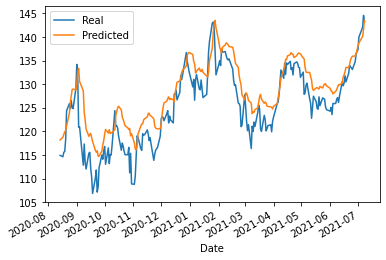

In [ ]:
# Plot the real vs predicted prices as a line chart
stocks.plot()